<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [73]:
#!pip uninstall keras
#!pip install tensorflow

In [74]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

#import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

import requests

# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

#import tensorflow as tf

from tensorflow.keras.preprocessing.text import text_to_word_sequence

#from keras.preprocessing.text import text_to_word_sequence

from gensim.models.callbacks import CallbackAny2Vec

### Datos

Utilizaremos como dataset 2 famosos libros de política.

In [75]:
"""

# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

"""

'\n\n# Descargar la carpeta de dataset\nimport os\nimport platform\nif os.access(\'./songs_dataset\', os.F_OK) is False:\n    if os.access(\'songs_dataset.zip\', os.F_OK) is False:\n        if platform.system() == \'Windows\':\n            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip\n        else:\n            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip\n    !unzip -q songs_dataset.zip\nelse:\n    print("El dataset ya se encuentra descargado")\n\n'

In [76]:
"""

# Posibles bandas
os.listdir("./songs_dataset/")

"""

'\n\n# Posibles bandas\nos.listdir("./songs_dataset/")\n\n'

In [77]:
"""

# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)
df.head()

"""

"\n\n# Armar el dataset utilizando salto de línea para separar las oraciones/docs\ndf = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)\ndf.head()\n\n"

In [78]:
result = requests.get("https://www.gutenberg.org/cache/epub/17405/pg17405.txt") # The Art of War - Sun Tzu

#result2 = requests.get("https://www.gutenberg.org/cache/epub/1232/pg1232.txt") # The Prince - Machiavelli

#result = result1.text + result2.text

df = pd.DataFrame(result.text.split('\n'), columns=['documents'])
df['documents'] = df['documents'].str.replace('\r','')
df = df[df['documents'].str.len() > 2] # Sacamos artículos, caracteres y filas con espacios vacíos
df.head()

,documents
0,﻿The Project Gutenberg eBook of The Art of War
1,
2,This ebook is for the use of anyone anywhere i...
3,most other parts of the world at no cost and w...
4,"whatsoever. You may copy it, give it away or r..."


In [79]:
df.shape[0]

1412

In [80]:
import re

def clean_strings(string_list):
    # Function to remove numbers and special characters
    cleaned_list = [re.sub(r'[^A-Za-z\s]', '', s) for s in string_list]
    return cleaned_list

# Example usage
#example_list = ["Hello123", "Python@#$%", "Clean#This123"]


In [81]:
# cada verso lo guardamos en una lista
text = list(df['documents'])

text = clean_strings(text)

text

['The Project Gutenberg eBook of The Art of War',
 '    ',
 'This ebook is for the use of anyone anywhere in the United States and',
 'most other parts of the world at no cost and with almost no restrictions',
 'whatsoever You may copy it give it away or reuse it under the terms',
 'of the Project Gutenberg License included with this ebook or online',
 'at wwwgutenbergorg If you are not located in the United States',
 'you will have to check the laws of the country where you are located',
 'before using this eBook',
 'Title The Art of War',
 'Author active th century BC Sunzi',
 'Translator Lionel Giles',
 'Release date December   eBook ',
 '                Most recently updated October  ',
 'Language English',
 'Original publication  ',
 ' START OF THE PROJECT GUTENBERG EBOOK THE ART OF WAR ',
 'SUN TZU ON THE ART OF WAR',
 'THE OLDEST MILITARY TREATISE IN THE WORLD',
 'Translated from the Chinese',
 'By LIONEL GILES MA ',
 '   This is the basic text of Sun Tz on the Art of War It was

In [82]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1412


In [83]:
sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
  filtered_words = [word for word in text_to_word_sequence(row[0]) if len(word) >= 3]
  sentence_tokens.append(filtered_words)

<ipython-input-83-d45528b10164>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_words = [word for word in text_to_word_sequence(row[0]) if len(word) >= 3]


In [84]:
## Demos un vistazo
sentence_tokens[:2]

[['\ufeffthe', 'project', 'gutenberg', 'ebook', 'the', 'art', 'war'], []]

In [85]:

# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

Consideraremos que cada secuencia para este dataset es un verso.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los versos del dataset y ses explorará la cantidad de términos presentes.



In [86]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1412


### Elegir el tamaño del contexto

In [87]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [88]:
text[0]

'The Project Gutenberg eBook of The Art of War'

In [89]:
segmented_sentences[0]

['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'art', 'of', 'war']

In [90]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

In [91]:
length_sentences[0]

9

Text(0.5, 1.0, 'Cantidad de palabras por documento')

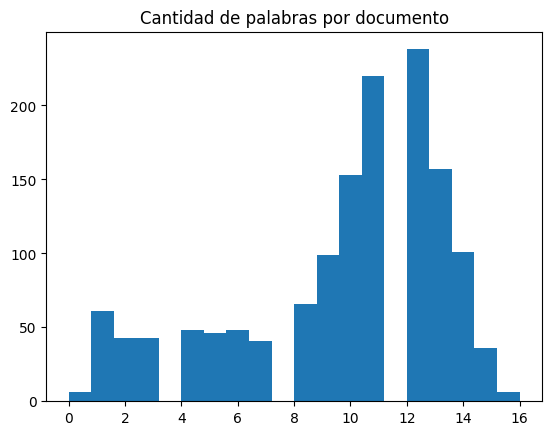

In [92]:
# podemos ver su distribución

# Se usa para entender que longitud de ventana debe usar el modelo
plt.hist(length_sentences,bins=20)
plt.title('Cantidad de palabras por documento')

In [93]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target

#max_context_size = int(np.percentile(length_sentences, 90)-1) # Puede cambiarse si es necesario.

max_context_size = 17

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 17


###  Tokenizar

In [94]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [95]:
tokenized_sentences[0]

[1, 24, 25, 113, 2, 1, 89, 2, 64]

In [96]:
segmented_sentences[0]

['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'art', 'of', 'war']

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [97]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

\Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

Por ejemplo, si tenemos el texto *La bella y graciosa moza marchóse a lavar la ropa* y nuestro contexto es de 5 palabras, tendremos:

- *La bella y graciosa moza*
- *bella y graciosa moza marchóse*
- *y graciosa moza marchóse a*
- *graciosa moza marchóse a lavar*
- *moza marchóse a lavar la*
- *marchóse a lavar la ropa*

In [98]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [99]:
len(tok_sent)

1129

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [100]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [101]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [102]:
train_seqs.shape

(9707, 18)

In [103]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [104]:
y.shape

(9707, 17)

In [105]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'of',
 3: 'to',
 4: 'and',
 5: 'is',
 6: 'a',
 7: 'in',
 8: 'be',
 9: 'you',
 10: 'are',
 11: 'will',
 12: 'not',
 13: 'if',
 14: 'it',
 15: 'with',
 16: 'or',
 17: 'on',
 18: 'by',
 19: 'his',
 20: 'for',
 21: 'that',
 22: 'your',
 23: 'enemy',
 24: 'project',
 25: 'gutenberg',
 26: 'he',
 27: 'when',
 28: 'we',
 29: 'this',
 30: 'army',
 31: 'from',
 32: 'ground',
 33: 'an',
 34: 'may',
 35: 'can',
 36: 'which',
 37: 'must',
 38: 'but',
 39: 'any',
 40: 'at',
 41: 'work',
 42: 'do',
 43: 'who',
 44: 'all',
 45: 'men',
 46: 'no',
 47: 'they',
 48: 'them',
 49: 'there',
 50: 'without',
 51: 'attack',
 52: 'general',
 53: 'as',
 54: 'its',
 55: 'victory',
 56: 'their',
 57: 'him',
 58: 'enemys',
 59: 'our',
 60: 'works',
 61: 'other',
 62: 'thus',
 63: 'soldiers',
 64: 'war',
 65: 'one',
 66: 'have',
 67: 'should',
 68: 'has',
 69: 'hence',
 70: 'into',
 71: 'make',
 72: 'electronic',
 73: 'use',
 74: 'fight',
 75: 'spies',
 76: 'out',
 77: 'country',
 78: 'these',
 79: '

In [106]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

2603

In [107]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'of': 2, 'to': 3, 'and': 4, 'is': 5, 'a': 6, 'in': 7, 'be': 8, 'you': 9, 'are': 10, 'will': 11, 'not': 12, 'if': 13, 'it': 14, 'with': 15, 'or': 16, 'on': 17, 'by': 18, 'his': 19, 'for': 20, 'that': 21, 'your': 22, 'enemy': 23, 'project': 24, 'gutenberg': 25, 'he': 26, 'when': 27, 'we': 28, 'this': 29, 'army': 30, 'from': 31, 'ground': 32, 'an': 33, 'may': 34, 'can': 35, 'which': 36, 'must': 37, 'but': 38, 'any': 39, 'at': 40, 'work': 41, 'do': 42, 'who': 43, 'all': 44, 'men': 45, 'no': 46, 'they': 47, 'them': 48, 'there': 49, 'without': 50, 'attack': 51, 'general': 52, 'as': 53, 'its': 54, 'victory': 55, 'their': 56, 'him': 57, 'enemys': 58, 'our': 59, 'works': 60, 'other': 61, 'thus': 62, 'soldiers': 63, 'war': 64, 'one': 65, 'have': 66, 'should': 67, 'has': 68, 'hence': 69, 'into': 70, 'make': 71, 'electronic': 72, 'use': 73, 'fight': 74, 'spies': 75, 'out': 76, 'country': 77, 'these': 78, 'up': 79, 'only': 80, 'states': 81, 'terms': 82, 'then': 83, 'so': 84, 'foundation'

In [108]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'project': 89, 'art': 20, 'of': 429, 'war': 29, 'gutenberg': 85, 'ebook': 14, 'the': 674, 'anywhere': 2, 'this': 71, 'use': 26, 'and': 312, 'is': 253, 'in': 237, 'united': 18, 'anyone': 5, 'for': 92, 'states': 21, 'at': 47, 'no': 36, 'with': 114, 'almost': 2, 'most': 14, 'world': 3, 'cost': 4, 'parts': 4, 'restrictions': 3, 'other': 31, 'reuse': 2, 'copy': 11, 'away': 14, 'may': 56, 'you': 150, 'it': 109, 'or': 97, 'terms': 21, 'under': 12, 'give': 8, 'whatsoever': 2, 'license': 17, 'included': 3, 'online': 4, 'located': 7, 'not': 116, 'wwwgutenbergorg': 5, 'are': 123, 'if': 109, 'have': 29, 'to': 381, 'where': 15, 'will': 117, 'check': 4, 'country': 23, 'laws': 10, 'before': 14, 'using': 9, 'title': 1, 'active': 3, 'th': 1, 'sunzi': 1, 'century': 1, 'author': 1, 'bc': 1, 'giles': 3, 'translator': 1, 'lionel': 2, 'december': 1, 'date': 3, 'release': 1, 'updated': 2, 'october': 1, 'recently': 1, 'english': 1, 'language': 2, 'publication': 1, 'original': 2, 's


### Definir el modelo

In [109]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(256, return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, None, 50)            │         130,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, None, 256)           │         314,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, None, 256)           │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 2604)          │         669,228 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,639,108 (6.25 MB)

 Trainable params: 1,639,108 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [110]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.h5")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [111]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=5, callbacks=[PplCallback(tokenized_sentences_val,history_ppl,patience=10)], batch_size=64)

Epoch 1/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - loss: 4.0233


 mean perplexity: 4945.843563916593 

Saved new model!
152/152 ━━━━━━━━━━━━━━━━━━━━ 96s 602ms/step - loss: 4.0168
Epoch 2/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - loss: 2.5203
 mean perplexity: 12987.547785333272 

152/152 ━━━━━━━━━━━━━━━━━━━━ 140s 588ms/step - loss: 2.5202
Epoch 3/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - loss: 2.4800
 mean perplexity: 9176.932469701967 

152/152 ━━━━━━━━━━━━━━━━━━━━ 85s 557ms/step - loss: 2.4800
Epoch 4/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - loss: 2.4683
 mean perplexity: 7839.309047934477 

152/152 ━━━━━━━━━━━━━━━━━━━━ 143s 562ms/step - loss: 2.4683
Epoch 5/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - loss: 2.4456
 mean perplexity: 12222.395540383455 

152/152 ━━━━━━━━━━━━━━━━━━━━ 142s 561ms/step - loss: 2.4457


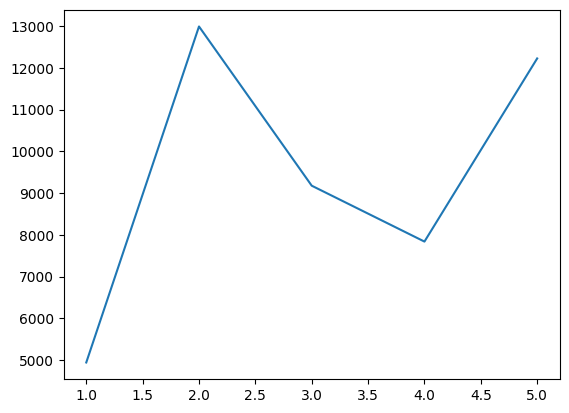

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [113]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.h5')


### Predicción de próxima palabra

In [114]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [115]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2e48fca9f86d5fc5ec.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://2e48fca9f86d5fc5ec.gradio.live


### Generación de secuencias

In [116]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [117]:
input_text='the art of '

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


'the art of  the the the the the the the the the the'

###  Beam search y muestreo aleatorio

In [118]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [119]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [120]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="the art of",temp=1,mode='sto')

In [121]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 23)

In [122]:
# veamos las salidas
decode(salidas[0])

['the art of the and the the of of']

# SOLUCION



In [123]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [124]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


In [125]:
def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [126]:

# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="the art of",temp=1,mode='sto')

# veamos las salidas
decode(salidas[0])

['the art of the that the the the easy']

In [127]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the art of",temp=2,mode='sto')
decode(salidas[0])

['the art of as impossible and out attack evening']

In [128]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the art of",temp=3,mode='sto')
decode(salidas[0])

['the art of they stripped form at intelligence constellations']

In [129]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the art of",temp=4,mode='sto')
decode(salidas[0])

['the art of possibility equipment flag relations revenue dead']

In [130]:
salidas = beam_search(model,num_beams=10,num_words=6,input="the art of",temp=5,mode='sto')
decode(salidas[0])

['the art of representations your they thousands signifies she']

# CONCLUSION:

No se logró predecír el título del libro.

# Explorando resultados utilizando SimpleRNN

In [131]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Define the Sequential model
model_simplernn = Sequential()

# Add an embedding layer
model_simplernn.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

# Add a SimpleRNN layer with 256 units and return_sequences=True
model_simplernn.add(SimpleRNN(256, return_sequences=True))

# Add another SimpleRNN layer with 256 units and return_sequences=True
model_simplernn.add(SimpleRNN(256, return_sequences=True))

# Output layer with softmax activation for multi-class classification
model_simplernn.add(Dense(vocab_size+1, activation='softmax'))

# Compile the model
model_simplernn.compile(
    loss=SparseCategoricalCrossentropy(),  # Sparse categorical crossentropy
    optimizer='rmsprop'                   # Optimizer
)

# Summarize the model
model_simplernn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, None, 50)            │         130,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, None, 256)           │          78,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, None, 256)           │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, None, 2604)          │         669,228 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,009,348 (3.85 MB)

 Trainable params: 1,009,348 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

In [132]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist_rnn = model_simplernn.fit(X, y, epochs=5, callbacks=[PplCallback(tokenized_sentences_val,history_ppl,patience=10)], batch_size=32)
model_simplernn.save('model_simplernn.h5')

Epoch 1/5
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 3.1007


 mean perplexity: 3401.062525397839 

Saved new model!
304/304 ━━━━━━━━━━━━━━━━━━━━ 76s 240ms/step - loss: 3.0992
Epoch 2/5
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 2.3196


 mean perplexity: 2836.812127758125 

Saved new model!
304/304 ━━━━━━━━━━━━━━━━━━━━ 68s 222ms/step - loss: 2.3194
Epoch 3/5
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 2.1506


 mean perplexity: 2429.618140586085 

Saved new model!
304/304 ━━━━━━━━━━━━━━━━━━━━ 81s 221ms/step - loss: 2.1505
Epoch 4/5
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 2.0153


 mean perplexity: 2238.713033837407 

Saved new model!
304/304 ━━━━━━━━━━━━━━━━━━━━ 82s 221ms/step - loss: 2.0152
Epoch 5/5
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 1.9387
 mean perplexity: 2531.634209039506 

304/304 ━━━━━━━━━━━━━━━━━━━━ 82s 220ms/step - loss: 1.9386


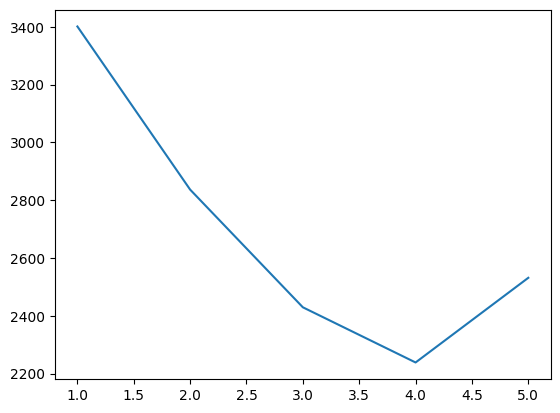

In [133]:
# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [134]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_simplernn = keras.models.load_model('model_simplernn.h5')

In [135]:
iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6a4394ca9d4c10cf83.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://6a4394ca9d4c10cf83.gradio.live


In [136]:
input_text='the art of '

generate_seq(model_simplernn, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


'the art of  war the enemy is the art of the full terms'

In [137]:
salidas = beam_search(model_simplernn, num_beams=10, num_words=6, input="the art of",temp=1,mode='sto')

# GANADOR! se logró predecír el título del libro.
decode(salidas[0])

['the art of war agreement the enemy is lays']

In [138]:
salidas = beam_search(model_simplernn, num_beams=10, num_words=6, input="the art of",temp=2,mode='sto')
decode(salidas[0])

['the art of ebook of his a full leaders']

In [139]:
salidas = beam_search(model_simplernn, num_beams=10, num_words=6, input="the art of",temp=3,mode='sto')

# GANADOR! se logró predecír el título del libro.
decode(salidas[0])

['the art of war removed bay the right succour']

In [140]:
salidas = beam_search(model_simplernn, num_beams=10, num_words=6, input="the art of",temp=4,mode='sto')
decode(salidas[0])

['the art of advances returning are you forward proclaim']

In [141]:
salidas = beam_search(model_simplernn, num_beams=10, num_words=6, input="the art of",temp=5, mode='sto')
decode(salidas[0])

['the art of and advantage banners applicable ounces rather']

# CONCLUSION:

Simple RNN es una mejor arquitectura ya que logra completar efectivamente el título del libro, con mayor frecuencia y con mismos valores de temperatura.